In [1]:
# 2.2 Installing and Importing the Necessary Libraries
from dotenv import dotenv_values
import pyodbc
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# Supress all warnings
import warnings 
warnings.filterwarnings('ignore')

# set display options to view all columns
pd.set_option("display.max_columns", None)                    

In [2]:
# Loading the data
#Load the environment variables 
environment_variables = dotenv_values(".env")

# get the values for the environment variables
server = environment_variables.get("server")
login = environment_variables.get("login")
password = environment_variables.get("password")
database = environment_variables.get("database")

# Create a database connection string using pyodbc
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password}"

#Establish a connection to the database
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful:", connection_string)    
except Exception as e:
    print("Connection failed:", e)

Connection successful: DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=LP2_project;PWD=Stat$AndD@t@Rul3


In [3]:
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM INFORMATION_SCHEMA.TABLES
        WHERE TABLE_SCHEMA = 'dbo'
        """
# Read data from the SQL query result into a DataFrame using the established database connection
schema_df = pd.read_sql(db_query, connection)

#  Check whether data has been retrieved successfully to confirm successful connection to database
try:
    schema_df = pd.read_sql(db_query, connection)    
    print("Data has been accesed")
    print()
    print(schema_df)    
except Exception as e:
    print("Failure to access data:", e)

Data has been accesed

  TABLE_CATALOG TABLE_SCHEMA                  TABLE_NAME  TABLE_TYPE
0         dapDB          dbo  LP2_Telco_churn_first_3000  BASE TABLE


In [4]:
# Load the LP2_Telco_churn_first 3000 data
# Define the SQL query to show specific tables in the database
db_query = """
        SELECT *
        FROM LP2_Telco_churn_first_3000        
        """
# Read data from the SQL query result into a DataFrame using the established database connection
train1 = pd.read_sql(db_query, connection)

# Display the DataFrame
train1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [5]:
# Obtain basic information about the dataset train1
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [6]:
# Check for any missing values within the dataset train1
train1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [7]:
# Check for any duplicated values in the dataset train1
train1.duplicated().sum()

0

In [8]:
# Check for the shape of the dataset train1
train1.shape

(3000, 21)

In [9]:
# Retrieve the Second Data Set 
# URL of the file to download
url = "https://github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/raw/main/LP2_Telco-churn-second-2000.csv"

# Local file path where the file will be saved
local_file_path = '../Data/Telco-churn-second-2000.csv'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content of the response to the specified file path
    with open(local_file_path, "wb") as f:
        f.write(response.content)
    print("File downloaded successfully")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

# Read the downloaded CSV file into a DataFrame
train2 = pd.read_csv(local_file_path)

# Display the DataFrame
train2.head()    

File downloaded successfully


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [10]:
# Check for the basic information for the train2 dataset
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [11]:
# Check for the sum of missing values in the train2 dataset
train2.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
# Check for any duplicated values in the train2 dataset
train2.duplicated().sum()

0

In [13]:
# Check for the shape or structure of the train2 dataset
train2.shape

(2043, 21)

In [14]:
# Loading the test data set
test_data = pd.read_csv(r"C:\Users\Edem Dzodzomenyo\azubi_data+ai_phase2_projects\Telco-churn-last-2000.csv")

test_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7912-SYRQT,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,3557-HTYWR,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.3
1997,4816-JBHOV,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.7
1998,8920-NAVAY,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [15]:
# obtain information about the data set
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [16]:
# Check for missing values within the test_data dataset
test_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [17]:
# Check for any duplicated values within the test_data dataset 
test_data.duplicated().sum()

0

In [18]:
# Look at the structure or shape of the test_data dataset
test_data.shape

(2000, 20)

In [19]:
# Concatenate train1 and train2

train_data = pd.concat ([train1, train2], ignore_index = True)

In [20]:
# Check for the basic information about the newly concatenated train_data dataset

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [21]:
# Look for any missing values in the train_data dataset 

train_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [22]:
# Check for any duplicated values in the train_data dataset

train_data.duplicated().sum()

0

In [23]:
# Check for the structure and shape of the train_data dataset

train_data.shape

(5043, 21)

In [24]:
# 1. Convert the datatype for totalCharges
train_data ['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors = 'coerce')

test_data ['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors = 'coerce')

In [25]:
train_data ['SeniorCitizen'] = train_data ['SeniorCitizen'].astype('object')

test_data ['SeniorCitizen'] = test_data ['SeniorCitizen'].astype('object')

In [26]:
# Verification or check on the conversion of the datatype for total charges
print (train_data['TotalCharges'].dtype)
print (test_data['TotalCharges'].dtype)

float64
float64


In [27]:
# Check for Unique Values 

def unique_values(dataframe):
    
    unique_summary = []

    for column in dataframe.columns:
        values = dataframe[column].unique()
        counts_values = len(values)

    
        unique_summary.append({
            'Column': column,
            'Unique_values': values,
            'Count_of_Unique_values': counts_values})

    usummary = pd.DataFrame(unique_summary)

    return usummary

In [28]:
# Check for the unique values of the train_data dataset

unique_values(train_data)

,Column,Unique_values,Count_of_Unique_values
0,customerID,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",5043
1,gender,"[Female, Male]",2
2,SeniorCitizen,"[0, 1]",2
3,Partner,"[True, False, No, Yes]",4
4,Dependents,"[False, True, No, Yes]",4
5,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
6,PhoneService,"[False, True, Yes, No]",4
7,MultipleLines,"[None, False, True, No, No phone service, Yes]",6
8,InternetService,"[DSL, Fiber optic, No]",3
9,OnlineSecurity,"[False, True, None, No, Yes, No internet service]",6


In [29]:
# Dropping the Customer ID Column
train_data.drop(columns = 'customerID',inplace=True)

test_data.drop(columns = 'customerID', inplace=True)

In [30]:
# Verification

train_data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
5,Female,0,False,False,8,True,True,Fiber optic,False,False,True,False,True,True,Month-to-month,True,Electronic check,99.650002,820.500000,True
6,Male,0,False,True,22,True,True,Fiber optic,False,True,False,False,True,False,Month-to-month,True,Credit card (automatic),89.099998,1949.400024,False
7,Female,0,False,False,10,False,None,DSL,True,False,False,False,False,False,Month-to-month,False,Mailed check,29.750000,301.899994,False
8,Female,0,True,False,28,True,True,Fiber optic,False,False,True,True,True,True,Month-to-month,True,Electronic check,104.800003,3046.050049,True
9,Male,0,False,True,62,True,False,DSL,True,True,False,False,False,False,One year,False,Bank transfer (automatic),56.150002,3487.949951,False


In [31]:
# Converting to Yes and No

labels = train_data.select_dtypes(include='object').columns.tolist()
labels

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [32]:
# Convert to Strings 

train_data[labels] = train_data[labels].astype(str)

In [33]:
# Add a function to make the necessary changes within the labels in the train_data dataset
binary = {
    "No": ["False", "0", "No phone service", "No internet service", "None"],
    "Yes": ["True", "1"]

}

def correct_columns(train_data, labels, binary):

    for column_name in labels:
        for key, values in binary.items ():
            train_data[column_name] = train_data[column_name].replace(values, key)
    return train_data

train_data = correct_columns(train_data, labels, binary)

In [34]:
# Verification of the changes within the train_data dataset brought about by the above function in [33]

unique_values(train_data)

,Column,Unique_values,Count_of_Unique_values
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
5,PhoneService,"[No, Yes]",2
6,MultipleLines,"[No, Yes]",2
7,InternetService,"[DSL, Fiber optic, No]",3
8,OnlineSecurity,"[No, Yes]",2
9,OnlineBackup,"[Yes, No]",2


In [35]:
# Create a list for the numerical values of data

num_cols = train_data[["tenure", "TotalCharges", "MonthlyCharges"]]

num_cols

,tenure,TotalCharges,MonthlyCharges
0,1,29.850000,29.850000
1,34,1889.500000,56.950001
2,2,108.150002,53.849998
3,45,1840.750000,42.299999
4,2,151.649994,70.699997
...,...,...,...
5038,24,1990.500000,84.800000
5039,72,7362.900000,103.200000
5040,11,346.450000,29.600000
5041,4,306.600000,74.400000


In [36]:
# Filling for Numerical - Total Changes 

train_data['TotalCharges'].fillna(train_data['TotalCharges'].median(), inplace = True)

In [37]:
# Select the categorical columns with missing values 
cat_cols = train_data[['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                       'StreamingTV','StreamingMovies','Churn']]

for col in cat_cols:

    train_data[col].replace("",np.nan,inplace = True)
    train_data[col].replace("Nan",np.nan,inplace = True)
    train_data[col].replace("nan",np.nan,inplace = True)
    train_data[col].fillna(train_data[col].mode()[0], inplace = True)

In [38]:
#Verifiyng 
for col in cat_cols:
    print(f"Unique values in {col}:{train_data[col].unique()}")

Unique values in MultipleLines:['No' 'Yes']
Unique values in OnlineSecurity:['No' 'Yes']
Unique values in OnlineBackup:['Yes' 'No']
Unique values in DeviceProtection:['No' 'Yes']
Unique values in TechSupport:['No' 'Yes']
Unique values in StreamingTV:['No' 'Yes']
Unique values in StreamingMovies:['No' 'Yes']
Unique values in Churn:['No' 'Yes']


In [39]:
# Verifying or checking on updates made to the unique values within the train_data dataset

unique_values(train_data)


,Column,Unique_values,Count_of_Unique_values
0,gender,"[Female, Male]",2
1,SeniorCitizen,"[No, Yes]",2
2,Partner,"[Yes, No]",2
3,Dependents,"[No, Yes]",2
4,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",73
5,PhoneService,"[No, Yes]",2
6,MultipleLines,"[No, Yes]",2
7,InternetService,"[DSL, Fiber optic, No]",3
8,OnlineSecurity,"[No, Yes]",2
9,OnlineBackup,"[Yes, No]",2


In [40]:
# Look at the description of count, mean, standard deviation, minimum values, maximum values, among others for 
# numerical variables
# in the train_data dataset
train_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2300.633691
std,24.529807,30.068133,2267.965879
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,418.000000
50%,29.000000,70.550003,1401.150024
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


Column: tenure
Skewness: 0.23
Kurtosis: -1.39
Mean: 32.58
Median: 29.0
------------------------------
Column: TotalCharges
Skewness: 0.94
Kurtosis: -0.28
Mean: 2302.06
Median: 1401.15
------------------------------
Column: MonthlyCharges
Skewness: -0.24
Kurtosis: -1.25
Mean: 65.09
Median: 70.55
------------------------------


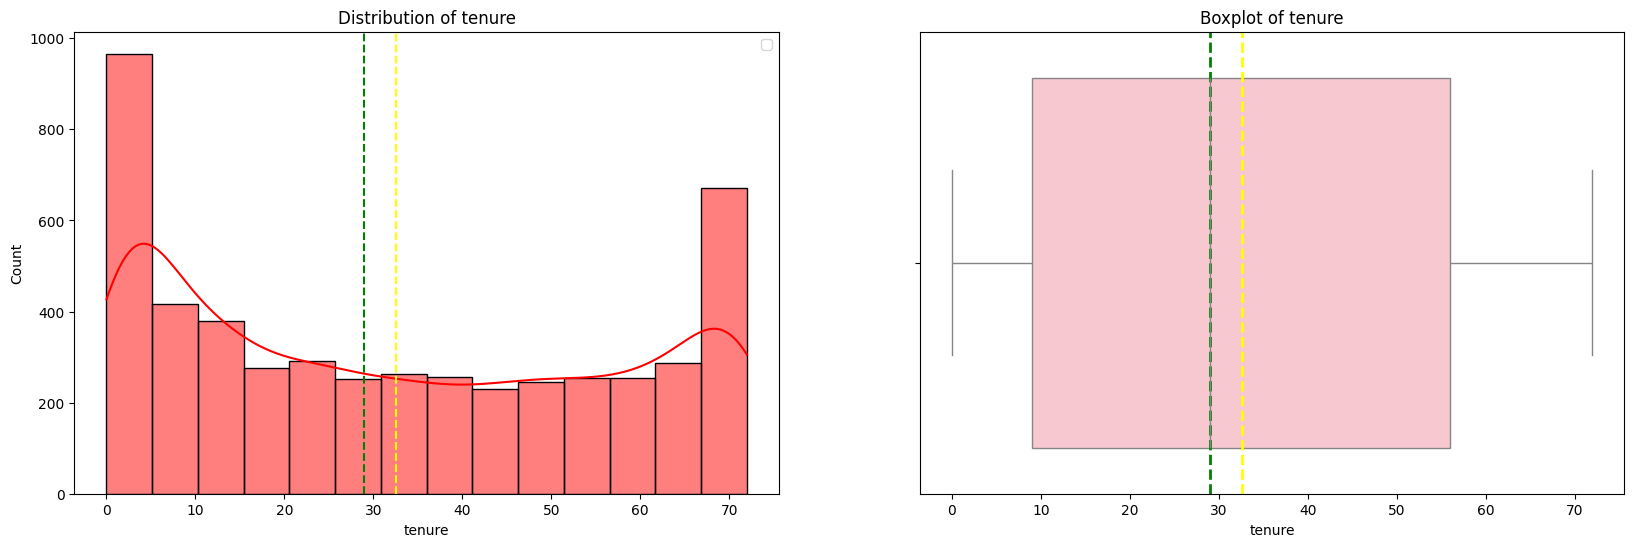

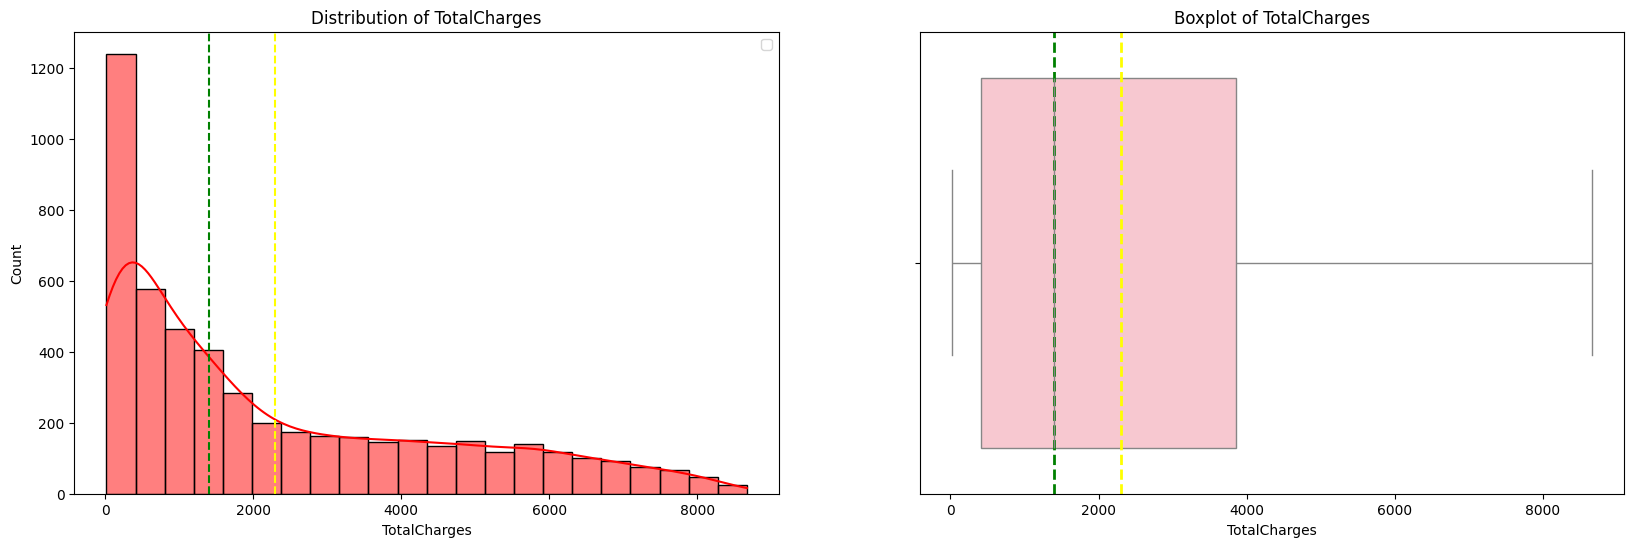

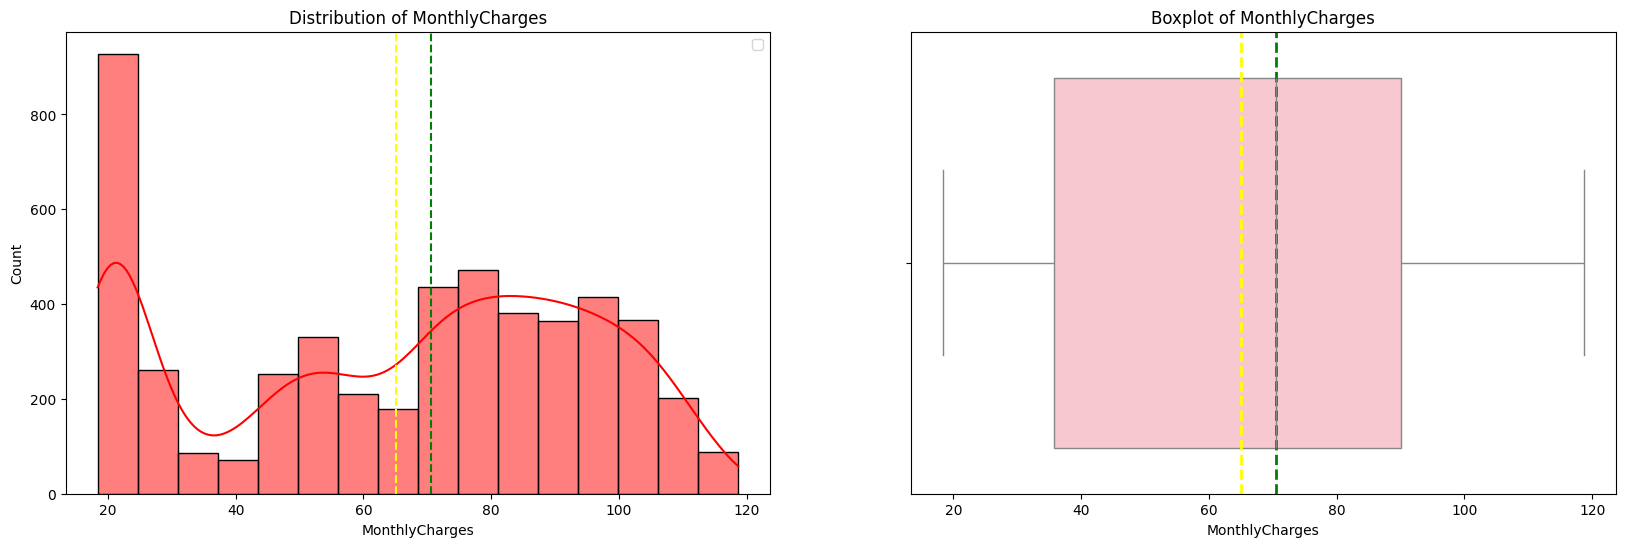

In [41]:
# Calculation of certain statistical measures and visualization of these plots of the train_data dataset

for col in num_cols:

    # calculate some statistical measures
    skewness = round(num_cols[col].skew(),2)
    kurtosis = round(num_cols[col].kurtosis(),2)
    mean = round(num_cols[col].mean(),2)
    median = round(num_cols[col].median(),2)

    #print the columns and their values 
    print(f"Column: {col}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print("-" * 30)

    # Set plot size for histoplot

    plt.figure(figsize = (20,6))

    plt.subplot(1,2,1)
    sns.histplot(num_cols[col], kde = True, color = 'red', edgecolor = 'black')
    plt.axvline(mean, color = 'yellow', linestyle = 'dashed')
    plt.axvline(median, color = 'green', linestyle = 'dashed')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()

    #set plot size for boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x = num_cols [col],color='pink')
    plt.axvline(mean, color = 'yellow', linestyle = 'dashed', linewidth=2)
    plt.axvline(median, color = 'green', linestyle = 'dashed', linewidth=2)
    plt.title(f"Boxplot of {col}")

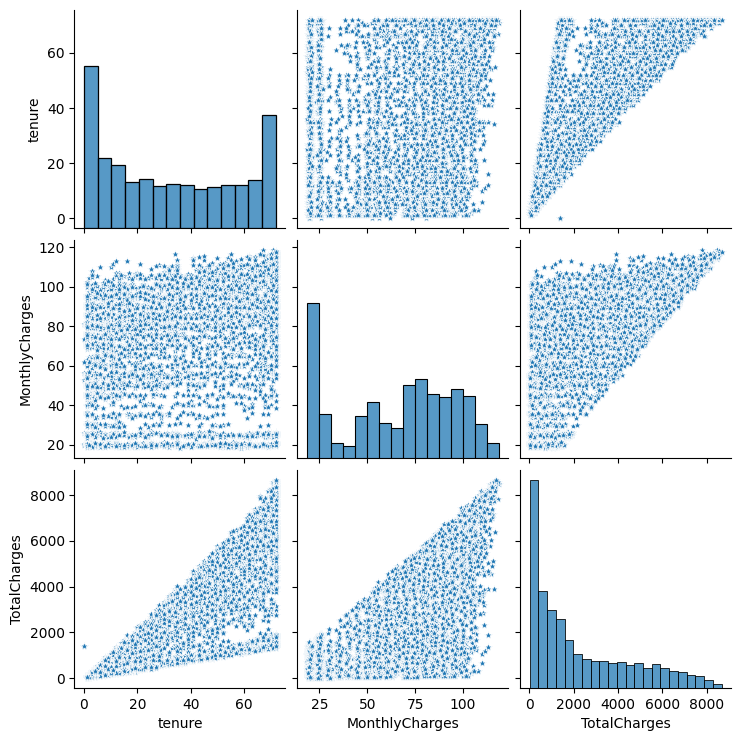

In [42]:
# Analysis of the numerical or numbers categories of columns within the train_data dataset
sns.pairplot(train_data [['tenure','MonthlyCharges', 'TotalCharges']], 
    markers='*',palette='viridis')

In [43]:
# Categorical column distributions


    


Plotting code modified with labels and titles.


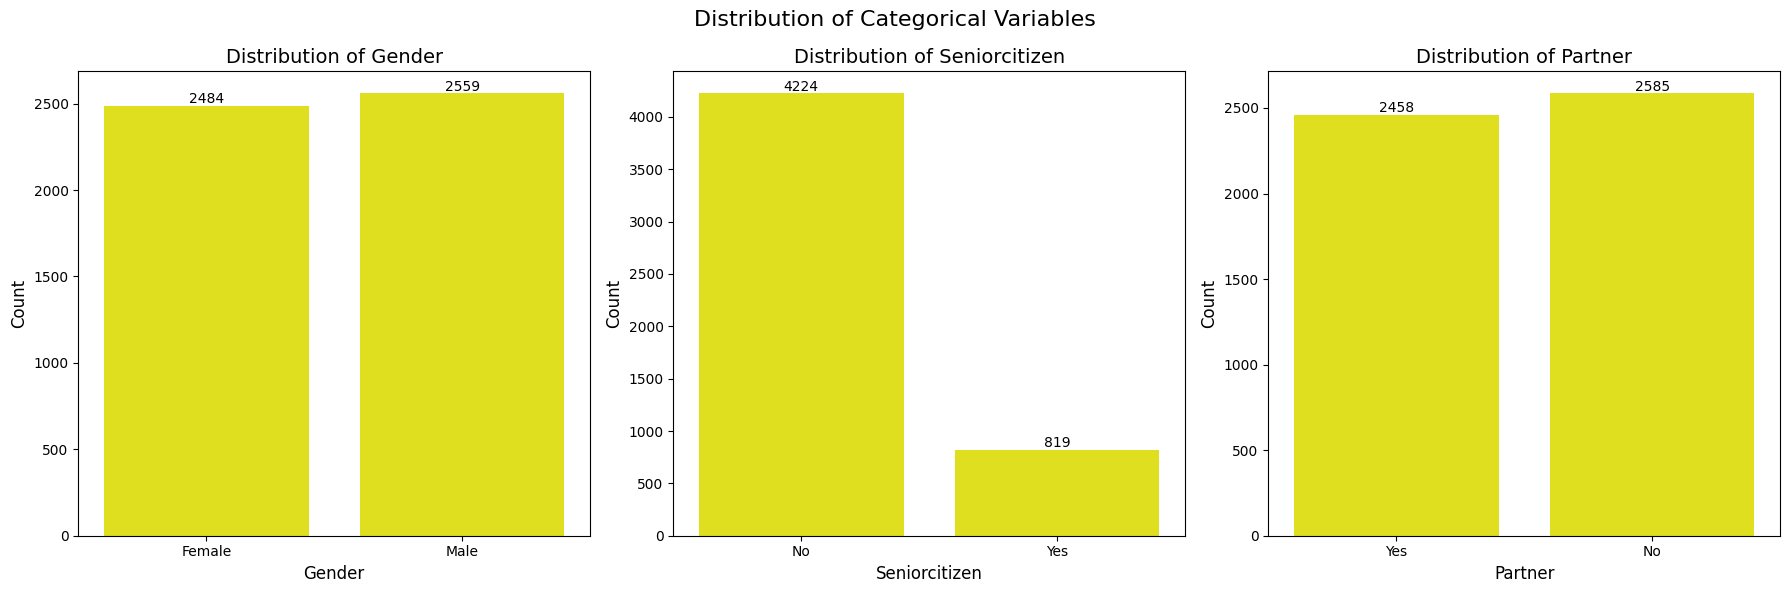

In [44]:
# Cell 1: Modify the plotting code to include labels for the axes and titles

import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to visualize
demography = ['gender', 'SeniorCitizen', 'Partner']

# Create subplots
fig, axes = plt.subplots(1, len(demography), figsize=(18, 6))

# Iterate over each column and create a countplot
for i, column in enumerate(demography):
    sns.countplot(x=train_data[column], ax=axes[i], color="yellow")
    axes[i].set_title(f'Distribution of {column.capitalize()}', fontsize=14)
    axes[i].set_xlabel(column.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # Add value labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}',
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 5), textcoords='offset points')

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

print("Plotting code modified with labels and titles.")


Plotting code modified with labels and titles.


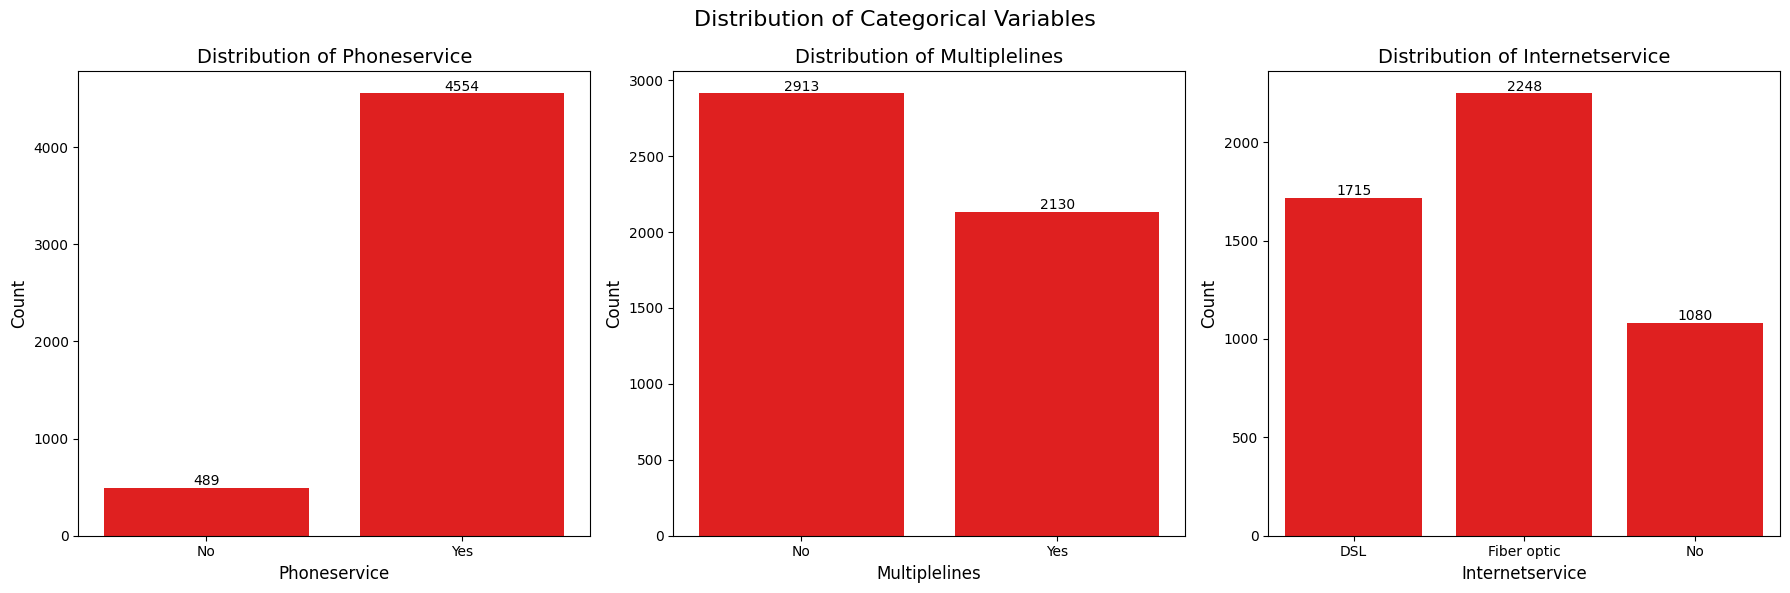

In [45]:
# Cell 1: Modify the plotting code to include labels for the axes and titles

# Define the columns to visualize
service_type = ['PhoneService', 'MultipleLines', 'InternetService']

# Create subplots
fig, axes = plt.subplots(1, len(service_type), figsize=(18, 6))

# Iterate over each column and create a countplot
for i, column in enumerate(service_type):
    sns.countplot(x=train_data[column], ax=axes[i], color="red")
    axes[i].set_title(f'Distribution of {column.capitalize()}', fontsize=14)
    axes[i].set_xlabel(column.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # Add value labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 5), textcoords='offset points')

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

print("Plotting code modified with labels and titles.")


Plotting code modified with labels and titles.


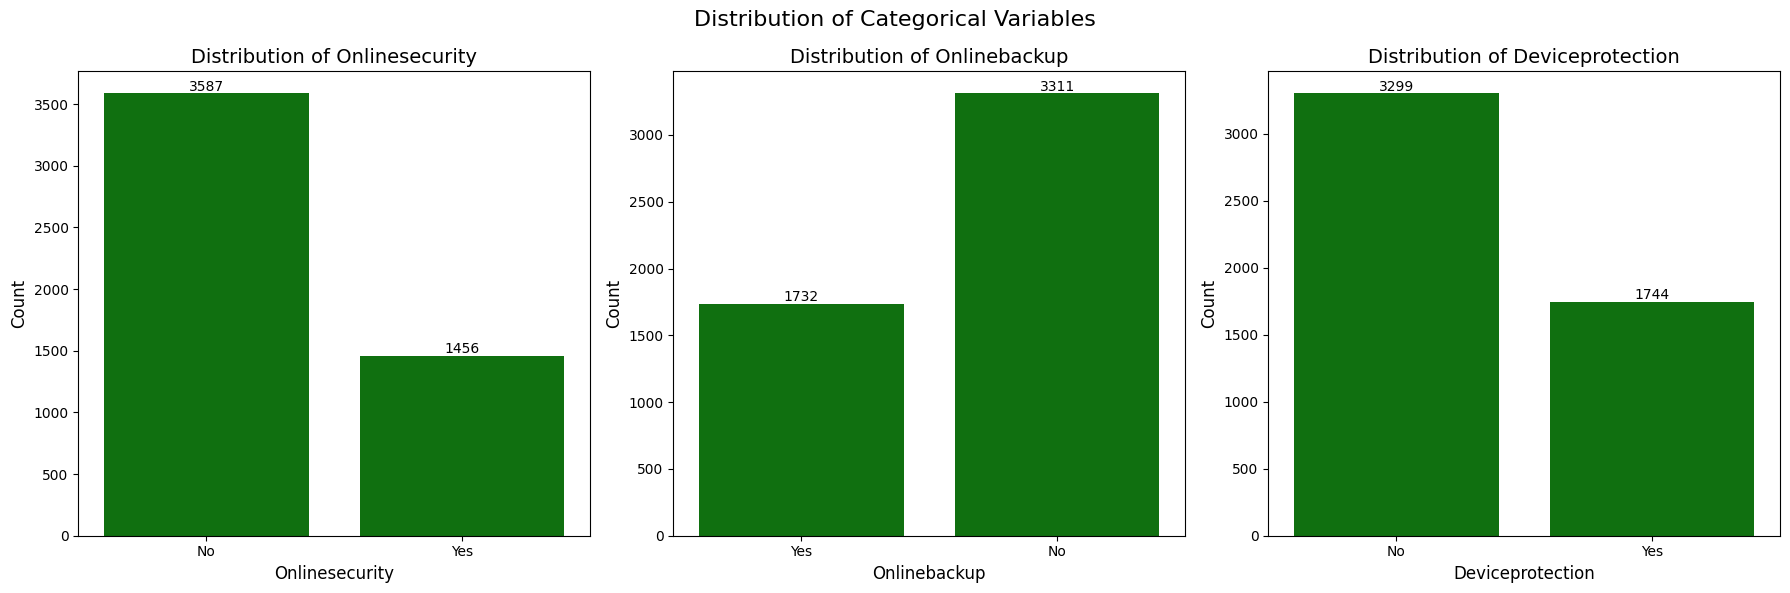

In [46]:
# Cell 1: Modify the plotting code to include labels for the axes and titles

# Define the columns to visualize
service_security = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

# Create subplots
fig, axes = plt.subplots(1, len(service_type), figsize=(18, 6))

# Iterate over each column and create a countplot
for i, column in enumerate(service_security):
    sns.countplot(x=train_data[column], ax=axes[i], color="green")
    axes[i].set_title(f'Distribution of {column.capitalize()}', fontsize=14)
    axes[i].set_xlabel(column.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # Add value labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 5), textcoords='offset points')

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

print("Plotting code modified with labels and titles.")


Plotting code modified with labels and titles.


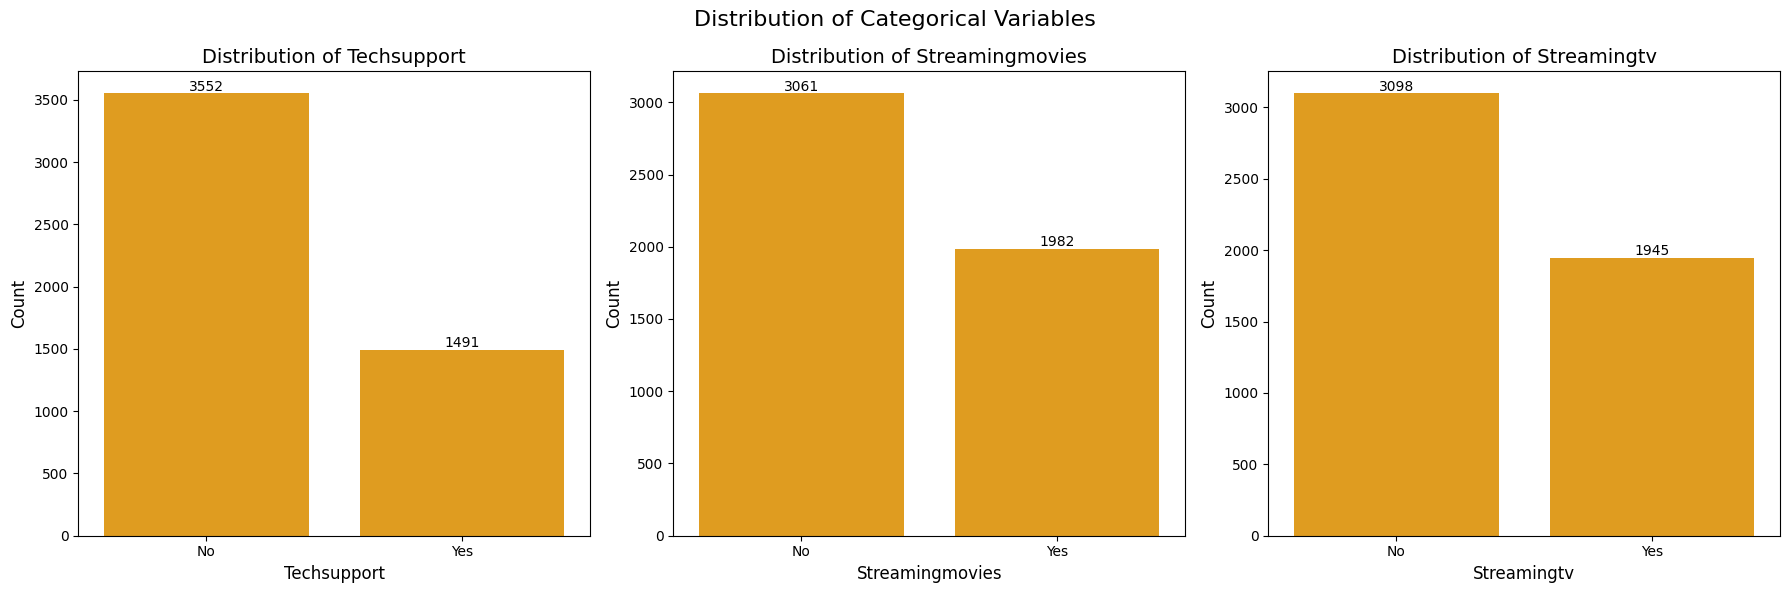

In [47]:
# Cell 1: Modify the plotting code to include labels for the axes and titles

# Define the columns to visualize
service_options_and_play = ['TechSupport', 'StreamingMovies', 'StreamingTV']

# Create subplots
fig, axes = plt.subplots(1, len(service_type), figsize=(18, 6))

# Iterate over each column and create a countplot
for i, column in enumerate(service_options_and_play):
    sns.countplot(x=train_data[column], ax=axes[i], color="orange")
    axes[i].set_title(f'Distribution of {column.capitalize()}', fontsize=14)
    axes[i].set_xlabel(column.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # Add value labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 5), textcoords='offset points')

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

print("Plotting code modified with labels and titles.")


Plotting code modified with labels and titles.


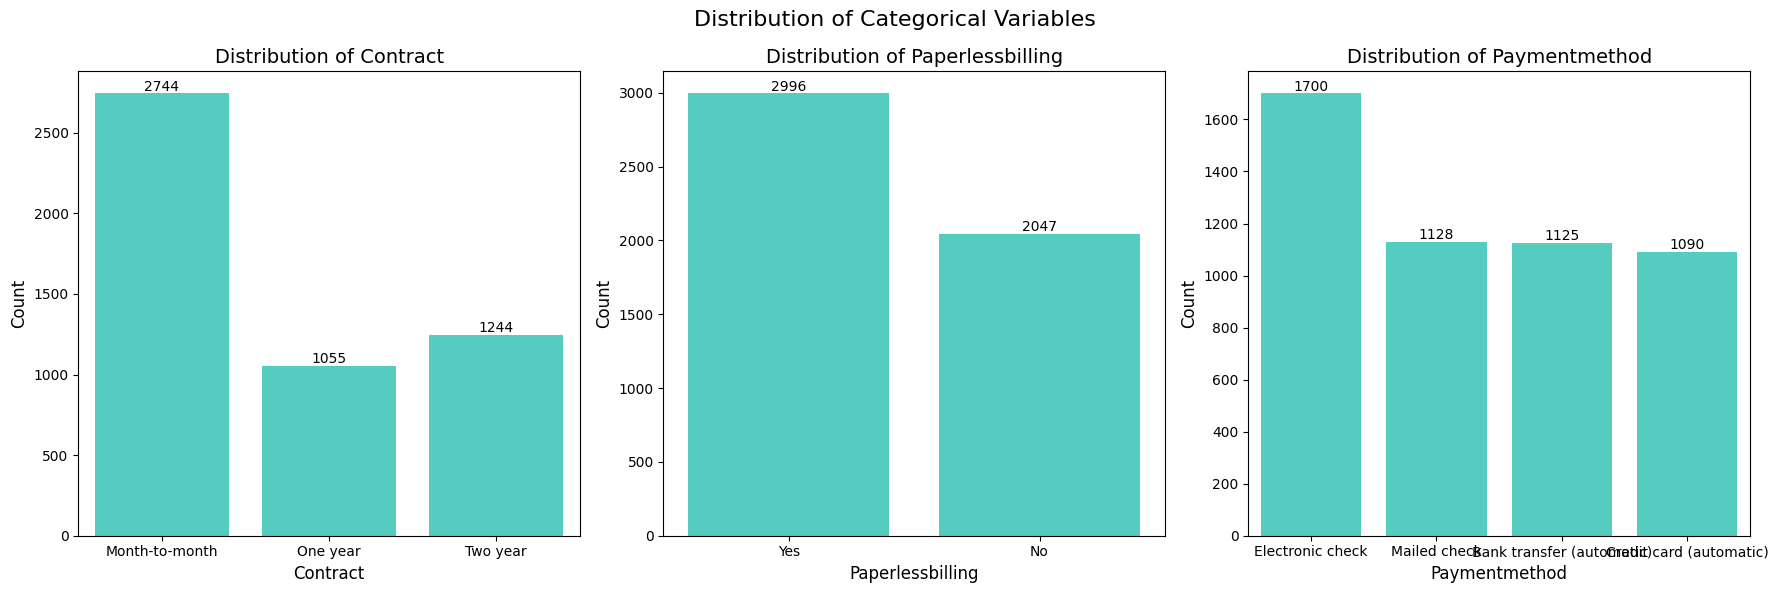

In [48]:
# Cell 1: Modify the plotting code to include labels for the axes and titles

# Define the columns to visualize
service_contracts_and_payments = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Create subplots
fig, axes = plt.subplots(1, len(service_contracts_and_payments), figsize=(18, 6))

# Iterate over each column and create a countplot
for i, column in enumerate(service_contracts_and_payments):
    sns.countplot(x=train_data[column], ax=axes[i], color="turquoise")
    axes[i].set_title(f'Distribution of {column.capitalize()}', fontsize=14)
    axes[i].set_xlabel(column.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    
    # Add value labels on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 5), textcoords='offset points')

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

print("Plotting code modified with labels and titles.")


In [49]:
#BIVARIATE

In [50]:
# Bivariate Analysis
all = ["gender","Partner","SeniorCitizen","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity",
       "OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod"]

In [51]:
import math

def cat_vs_target (data, all, target):

    n_rows = math.ceil(len (all)/3)

    fig,axes = plt.subplots(n_rows, 3, figsize = (20,6 * n_rows))
    axes = axes.flatten()

    for i, column in enumerate(all):
        ax = axes[i]

        sns.countplot(data=train_data, x = column, hue = target, ax=ax)

        ax.set_xlabel(column)
        ax.set_ylabel("count")
        ax.set_title(f"{column} vs {target}")
        ax.set_xticks

#add labels 
        total = len(train_data)
        for container in ax.containers:
            label = [f'{h.get_height()} ({h.get_height()/total * 100:.2f}%)' if h.get_height() > 0 else '' for h in container] 
            ax.bar_label(container, label)

        ax.legend(title = "churn status", loc = 'upper left')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

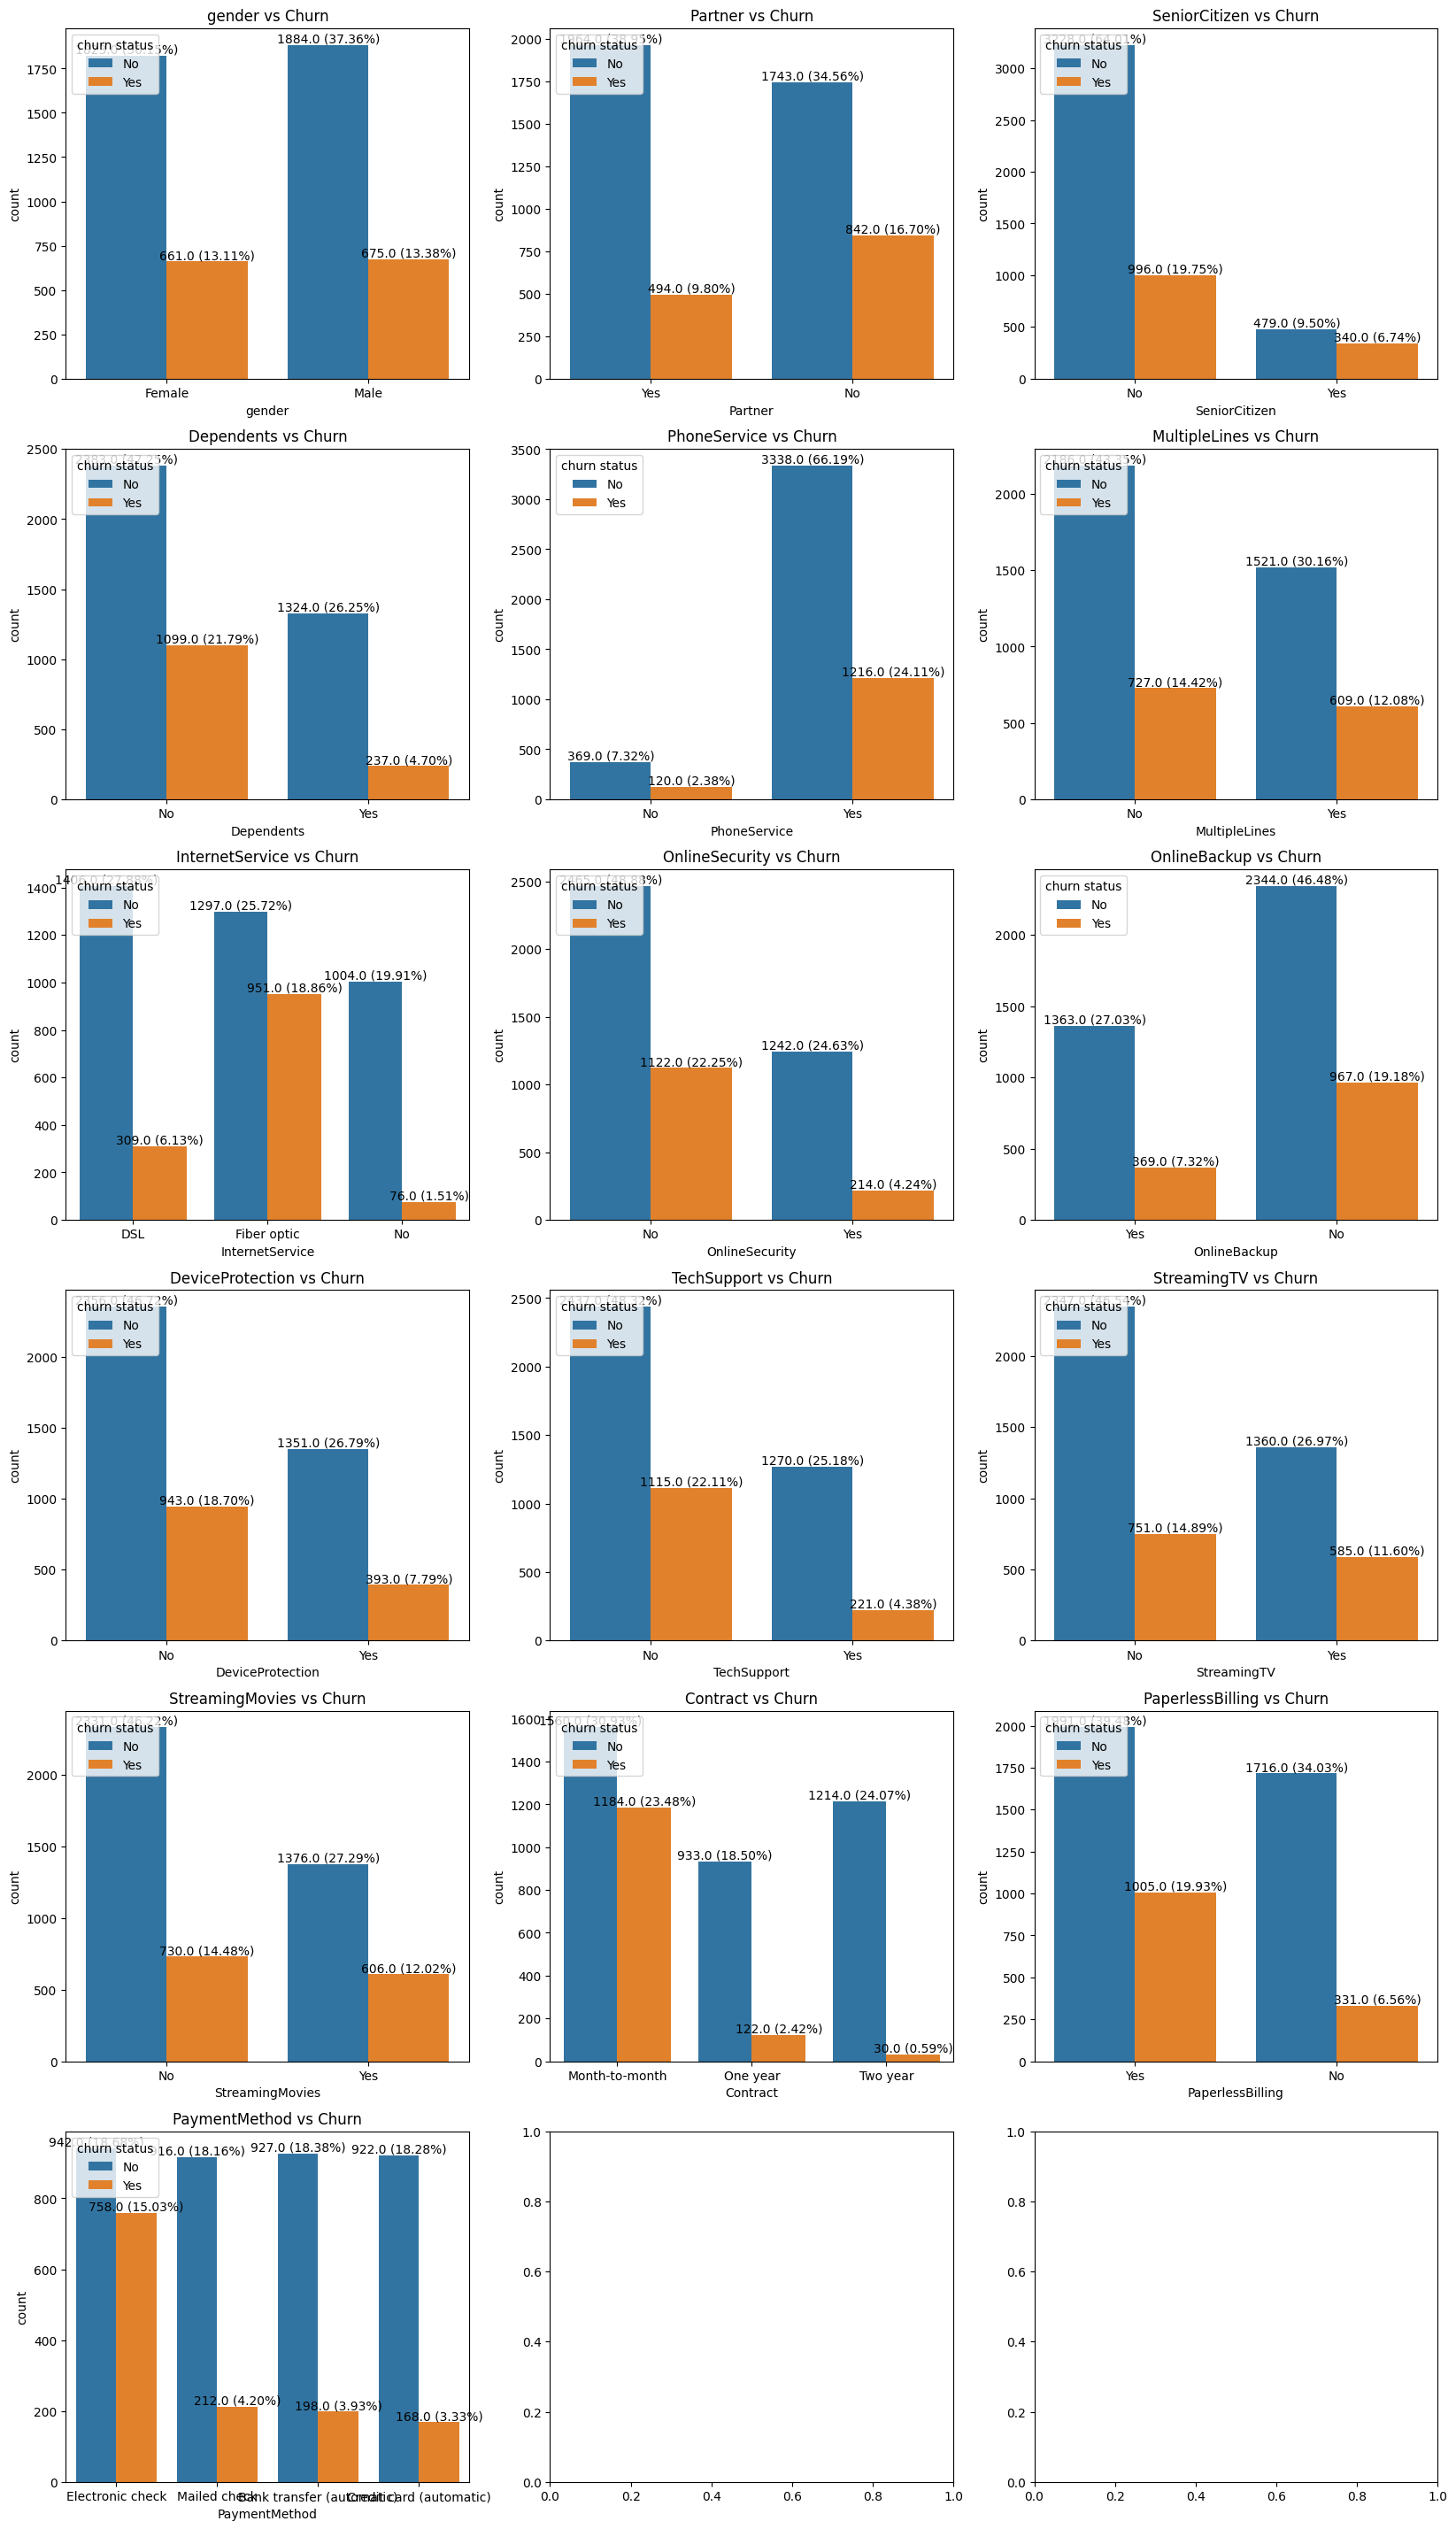

In [52]:
cat_vs_target(train_data, all, "Churn")

In [53]:
#MULTIVARIATE ANALYSIS

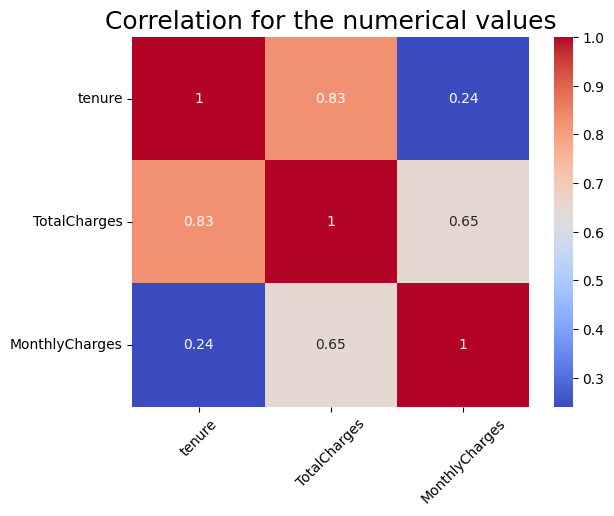

In [54]:
# conducting a correlation graph for the multivariate analysis
correlation = num_cols.corr()

correlation

# plot correlation

sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

plt.title('Correlation for the numerical values', fontsize = 18)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)

plt.show()

In [55]:
#HYPOTHESIS TESTING

In [56]:
#grouping

train_data['mc_category'] = np.where(train_data['MonthlyCharges'] > train_data['MonthlyCharges'].mean(),'high', 'low')    

In [57]:
high_mc = train_data[train_data['mc_category'] == 'high']

high_mc

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,mc_category
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,high
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes,high
6,Male,No,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No,high
8,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800003,3046.050049,Yes,high
12,Male,No,Yes,No,58,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Credit card (automatic),100.349998,5681.100098,No,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,Male,No,No,No,19,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.700000,1495.100000,No,high
5038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No,high
5039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No,high
5041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes,high


In [58]:
low_mc = train_data[train_data['mc_category'] == 'low']

low_mc

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,mc_category
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No,low
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No,low
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,low
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No,low
7,Female,No,No,No,10,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.750000,301.899994,No,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,Female,No,No,No,2,Yes,No,No,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,20.050000,39.250000,No,low
5031,Male,Yes,Yes,No,55,Yes,Yes,DSL,Yes,Yes,No,No,No,No,One year,No,Credit card (automatic),60.000000,3316.100000,No,low
5036,Female,No,No,No,12,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.650000,743.300000,No,low
5037,Female,No,No,No,72,Yes,No,No,No,No,No,No,No,No,Two year,Yes,Bank transfer (automatic),21.150000,1419.400000,No,low


In [59]:
## Method 1 

# Using the chi square

from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(train_data['Churn'],train_data['mc_category'])

contingency_table

mc_category,high,low
Churn,,
No,1830,1877
Yes,981,355


In [60]:
#perform the chi_square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print (f"chi2: {chi2:.2f}, p_value: {p_value}, degree of freedom : {dof}")

chi2: 229.50, p_value: 7.648936379911372e-52, degree of freedom : 1


In [61]:
# decision to keep or not 
alpha = 0.05

if p_value < alpha:
    print ("We reject the null hypothesis")
else:
    print ("We fail to reject the null hypothesis")

We reject the null hypothesis


In [62]:
# Method 2 
churned = train_data[train_data['Churn'] == 'Yes']['MonthlyCharges']

not_churned = train_data[train_data['Churn'] == 'No']['MonthlyCharges']



In [63]:
# import test
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(churned, not_churned)

print('u statistics:', u_stat)

print('p value:', p_value)

u statistics: 3100791.0
p value: 1.2019873209608733e-42


In [64]:
# decision to keep or not 
alpha = 0.05

if p_value < alpha:
    print ("We reject the null hypothesis")
else:
    print ("We fail to reject the null hypothesis")

We reject the null hypothesis


In [65]:
# T-test: if monthly charges are continuous and normally distributed

from scipy.stats import ttest_ind

# Split the data ino 2 groups
churned = train_data[train_data['Churn'] == 'Yes']['MonthlyCharges']
not_churned = train_data[train_data['Churn'] == 'No']['MonthlyCharges']

# Perform the t-test
t_stat,p_value = ttest_ind(churned, not_churned)

print(f"T-statistic: {t_stat:.2f}, p-value: {p_value}")

T-statistic: 14.65, p-value: 1.257546511354579e-47


In [66]:
# decision to keep or not 
alpha = 0.05

if p_value < alpha:
    print ("We reject the null hypothesis")
else:
    print ("We fail to reject the null hypothesis")

We reject the null hypothesis


Question 1 - What is the average tenure of of customers who churned compared to those who stayed?

In [67]:
criteria = train_data['Churn'] == 'Yes'

left_customer = train_data[criteria]

stayed_customer = train_data[~criteria]

# calculate the average tenure 
avg_tenure_churned = left_customer['tenure'].mean()

avg_tenure_not_churned = stayed_customer['tenure'].mean()

#print
print(f"Average of churned customers: {avg_tenure_churned:.0f}")
print(f"Average of not churned (staying) customers: {avg_tenure_not_churned:.0f}")

Average of churned customers: 18
Average of not churned (staying) customers: 38


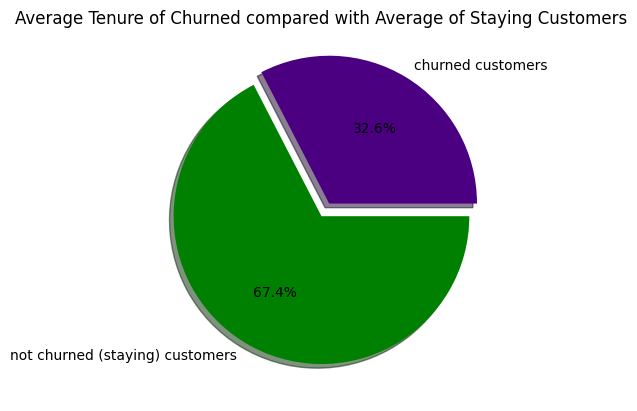

In [68]:
#plot the visualization

label = ['churned customers', 'not churned (staying) customers']
sizes = [avg_tenure_churned , avg_tenure_not_churned]
colors = ['indigo', 'green']
explode = (0.1, 0)

plt.pie(sizes, explode = explode, labels = label, colors = colors, autopct = '%1.1f%%', shadow=True)
plt.title('Average Tenure of Churned compared with Average of Staying Customers')
plt.show()

Question 2 - Do customers with partners or dependents have a lower churn rate?

In [69]:
#Calculate churn rate for customers with partners
partner_churn_rate = train_data[train_data['Partner'] == 'Yes']['Churn'].value_counts(normalize=True)['Yes']

# Calculate churn rate for customers without partners
no_partner_churn_rate = train_data[train_data['Partner'] == 'No']['Churn'].value_counts(normalize=True)['Yes']

# Calculate churn rate for customers with dependents
dependent_churn_rate = train_data[train_data['Dependents'] == 'Yes']['Churn'].value_counts(normalize=True)['Yes']

# Calculate churn rate for customers without dependents
no_dependent_churn_rate = train_data[train_data['Dependents'] == 'No']['Churn'].value_counts(normalize=True)['Yes']

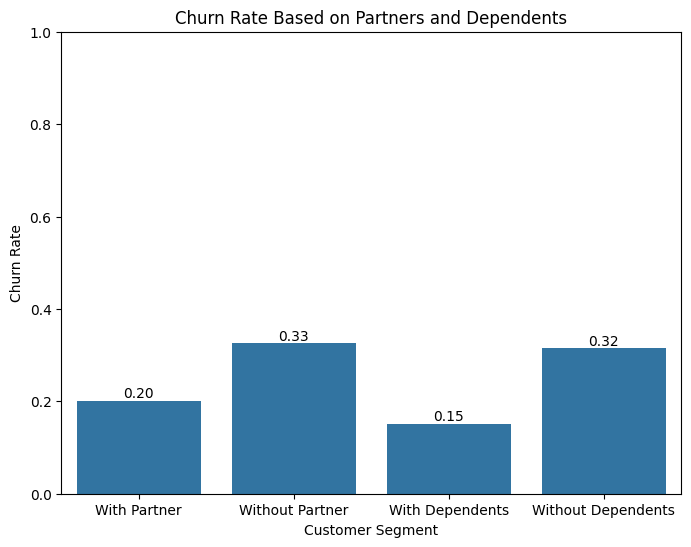

In [70]:
# Visualize the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['With Partner', 'Without Partner', 'With Dependents', 'Without Dependents'], 
            y=[partner_churn_rate, no_partner_churn_rate, dependent_churn_rate, no_dependent_churn_rate])
plt.title('Churn Rate Based on Partners and Dependents')
plt.xlabel('Customer Segment')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)  
# Set y-axis limits from 0 to 1

# Adding data labels
for index, value in enumerate([partner_churn_rate, no_partner_churn_rate, dependent_churn_rate, no_dependent_churn_rate]):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

Question 3 - Is there a correlation between Contract Item and Customer Churn?

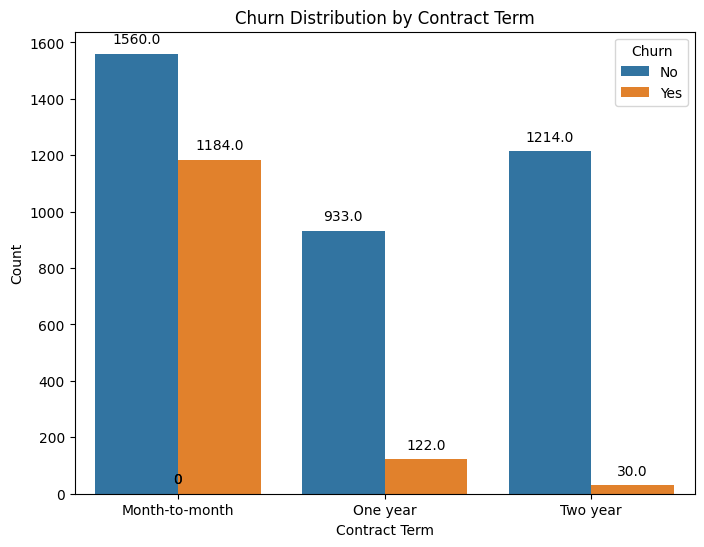


Churn Rate by Contract Term:
Churn                 No       Yes
Contract                          
Month-to-month  0.568513  0.431487
One year        0.884360  0.115640
Two year        0.975884  0.024116

Chi-square Test Results for Contract Term and Churn:
Chi-square value: 882.0901975577578
p-value: 2.86119415951209e-192


In [71]:
# Plotting the relationship between contract term and churn
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=train_data, x='Contract', hue='Churn')

# Adding data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.title('Churn Distribution by Contract Term')
plt.xlabel('Contract Term')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.show()

# Calculating churn rate by contract term
churn_rate_contract = train_data.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
print("\nChurn Rate by Contract Term:")
print(churn_rate_contract)

# Chi-square test for association between contract term and churn
chi2, p_val, _, _ = chi2_contingency(pd.crosstab(train_data['Contract'], train_data['Churn']))
print("\nChi-square Test Results for Contract Term and Churn:")
print("Chi-square value:", chi2)
print("p-value:", p_val)

In [72]:
churned_customers = train_data[train_data['Churn'] == 'Yes']
common_payment_methods = churned_customers['PaymentMethod'].value_counts()

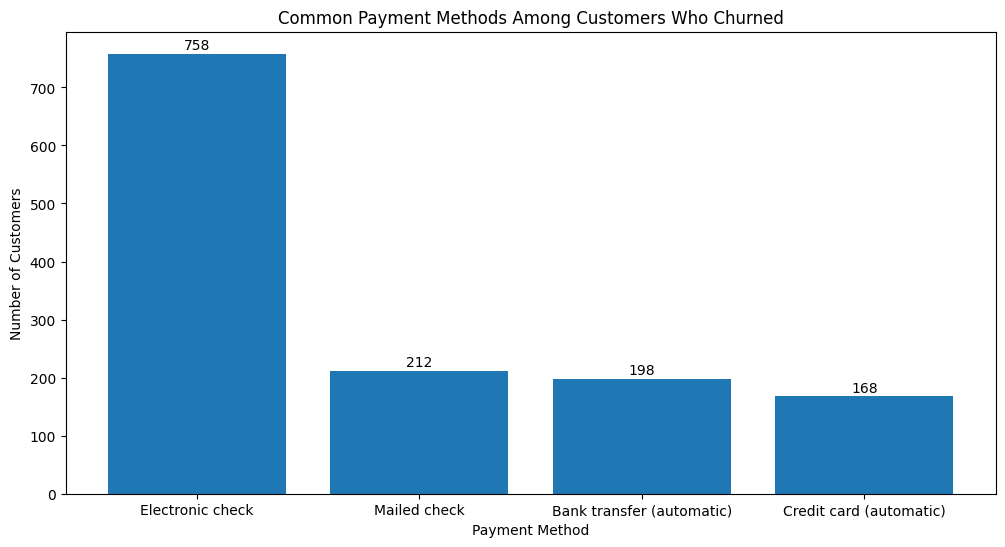

In [73]:
#plot to find the most common payment methods among the customers who churned

plt.figure(figsize=(12,6))
plt.bar(common_payment_methods.index, common_payment_methods.values)
plt.title('Common Payment Methods Among Customers Who Churned')
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')

# Adding data labels above the bars
# Adding data labels above the bars
for i, v in enumerate(common_payment_methods.values):
    plt.text(i, v + 2, str(v), ha='center', va='bottom')

plt.show()

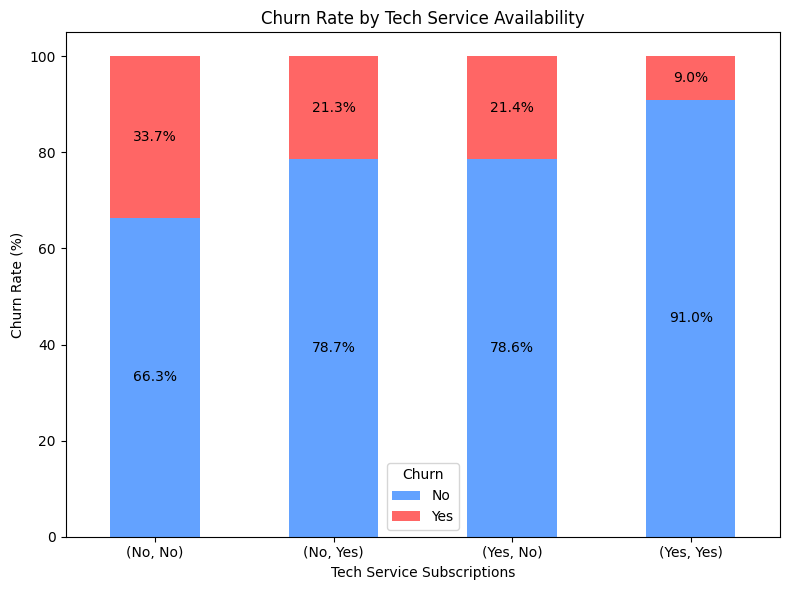

In [74]:
# Group data by subscription to tech services and churn
tech_service_groups = train_data.groupby(['OnlineSecurity', 'TechSupport', 'Churn'])['gender'].count().unstack(fill_value=0)

# Calculate churn rate for each group
churn_rate = tech_service_groups.div(tech_service_groups.sum(axis=1), axis=0) * 100

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))
churn_rate.plot(kind='bar', stacked=True, color=['#63A2FF', '#FF6665'], ax=ax)
plt.xlabel('Tech Service Subscriptions')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Tech Service Availability')
plt.xticks(rotation=0)

# Add percentage labels to bars
for i, (index, row) in enumerate(churn_rate.iterrows()):
    cum_value = 0
    for churn, value in row.items():
        ax.text(i, cum_value + value/2, f"{value:.1f}%", ha='center', va='center')
        cum_value += value

plt.legend(title='Churn', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

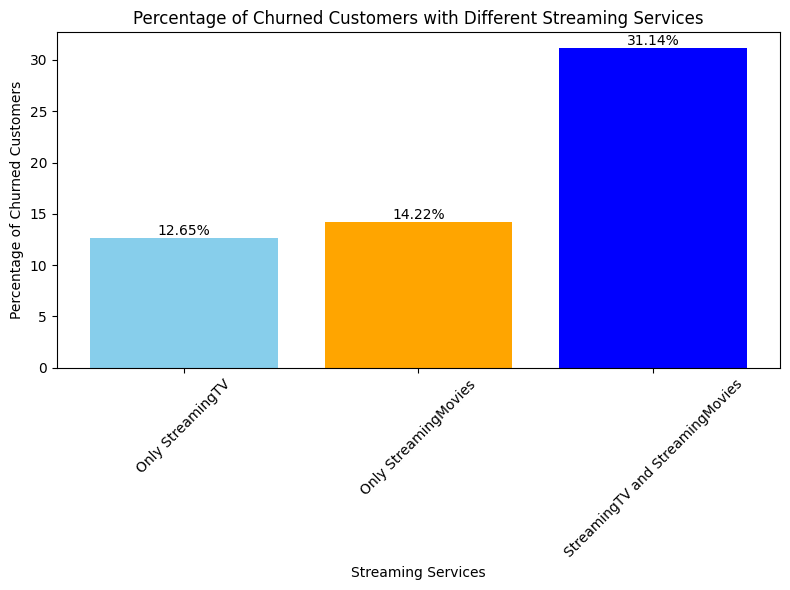

In [75]:
# Filter the DataFrame to include only churned customers
churned_customers = train_data[train_data['Churn'] == 'Yes']
 
# Calculate the number of churned customers with different streaming services
streaming_tv_churned_count = len(churned_customers[(churned_customers['StreamingTV'] == 'Yes') & (churned_customers['StreamingMovies'] == 'No')])
streaming_movies_churned_count = len(churned_customers[(churned_customers['StreamingTV'] == 'No') & (churned_customers['StreamingMovies'] == 'Yes')])
both_streaming_churned_count = len(churned_customers[(churned_customers['StreamingTV'] == 'Yes') & (churned_customers['StreamingMovies'] == 'Yes')])
 
# Calculate the total number of churned customers
total_churned_customers = len(churned_customers)
 
# Calculate the percentage of churned customers for each category
percentage_streaming_tv_churned = (streaming_tv_churned_count / total_churned_customers) * 100
percentage_streaming_movies_churned = (streaming_movies_churned_count / total_churned_customers) * 100
percentage_both_streaming_churned = (both_streaming_churned_count / total_churned_customers) * 100
 
# Plotting the grouped bar plot
categories = ['Only StreamingTV', 'Only StreamingMovies', 'StreamingTV and StreamingMovies']
percentages = [percentage_streaming_tv_churned, percentage_streaming_movies_churned, percentage_both_streaming_churned]
 
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=['skyblue', 'orange', 'blue'])
 
# Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
 
plt.xlabel('Streaming Services')
plt.ylabel('Percentage of Churned Customers')
plt.title('Percentage of Churned Customers with Different Streaming Services')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DATA PREPARATION

In [76]:
# Save a copy of the original trained data
train_mod = train_data.copy()

In [77]:
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 


In [78]:
# Check to see if it is balanced
train_mod['Churn'].value_counts()

Churn
No     3707
Yes    1336
Name: count, dtype: int64

In [79]:
# method 1 -- resample 
from sklearn.utils import resample

churn_major = train_mod[train_mod["Churn"] == "No"]
churn_minor = train_mod[train_mod["Churn"] == "Yes"]

minor_resampled = resample(churn_minor, replace=True, n_samples = len(churn_major),random_state = 42)

train_mod = pd.concat([churn_major, minor_resampled])
train_mod["Churn"].value_counts()

Churn
No     3707
Yes    3707
Name: count, dtype: int64

In [80]:
# Splitting the data
from sklearn.model_selection import train_test_split

In [81]:
X = train_data.drop(columns="Churn", axis = 1)
y = train_data["Churn"]

In [82]:
encoder = LabelEncoder()

y = encoder.fit_transform(y)

In [83]:
# Split the data into X-train and y-train 
X_train, X_val, y_train, y_val = train_test_split (X,y, test_size = 0.2, random_state=42)

In [84]:
# Check the size of the training and evaluation sets with the shape() function
(X_train.shape, y_train.shape), (X_train.shape, y_train.shape), (X_val.shape)

(((4034, 20), (4034,)), ((4034, 20), (4034,)), (1009, 20))

In [85]:
# Separate numeric and categorical columns
num_cols = X.select_dtypes('int64','float64').columns
cat_cols = X.select_dtypes('object').columns


#Separati#ng into numerical and categorical columns
#num_columns = X.select_dtypes(include=['int64', 'float64']).columns
 
#cat_columns = X.select_dtypes(include=['object']).columns #['InternetService', 'Contract', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetSer']

In [86]:
#Preprocess for numerical data
 
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline(steps = [
    ('scaler', RobustScaler()),
    ('qt', QuantileTransformer(output_distribution = 'normal'))
])

 
# Preprocess for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',  sparse_output=False))
])
 
 
# Combine preprocessing steps
preprocessor = ColumnTransformer( transformers=[
        ('numerical', num_pipe, num_cols),
        ('categorical', categorical_transformer, cat_cols)
    ])
 
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('qt',
                                                  QuantileTransformer(output_distribution='normal'))]),
                                 Index(['tenure'], dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'mc_category'],
      dtype='object'))])

In [87]:
# Model selection - import the host of models 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [88]:
from imblearn.pipeline import Pipeline as ImbPipeline

models = [
    ('KNN', KNeighborsClassifier(n_neighbors=10)),
    ('LR', LogisticRegression(max_iter=1000, random_state=42,verbose=0)),
    ('RF', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)),
    ('SVC', SVC(probability=True,random_state=42, C=1.0,gamma='scale')),
    ('GB', GradientBoostingClassifier(random_state=42,n_estimators=100,learning_rate=0.1,max_depth=3)),
    ('XB', XGBClassifier(random_state=42,use_label_encoder= False, eval_metrics = "logloss",n_estimators=100))
]

# Define Oversampling Technique
sampler = SMOTE(random_state=42)

pipelines = []

for model, classifier in models:
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('SMOTE_sampler', sampler),
        ('model', classifier),
    ])
    pipelines.append((model,pipeline))

In [89]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [90]:
eval_result = { }

for model, classifier in models:

    pipeline = ImbPipeline(steps = [
                  ('preprocessor', preprocessor),
                  ('SMOTE_sampler', sampler),
                  ('model', classifier)
    ])

    pipeline.fit(X_train, y_train)

    X_val_processed = pipeline.named_steps['preprocessor'].transform(X_val)

    y_pred = pipeline.named_steps['model'].predict(X_val_processed)

 

    accuracy = accuracy_score (y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    precision = precision_score (y_val,y_pred)
    recall = recall_score(y_val,y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)

    eval_result[model] = {
    'accuracy': accuracy,
    'f1_score': f1,
    'precision': precision,
    'recall': recall,
    'predictions': y_pred,
    'confusion_matrix' : conf_matrix

    }

scores_df = pd.DataFrame(eval_result).transpose()
scores_dff = scores_df.sort_values(by = "f1_score", ascending = False)

print ("Model Scores: ")
scores_dff


Model Scores: 


,accuracy,f1_score,precision,recall,predictions,confusion_matrix
GB,0.799802,0.65411,0.618123,0.694545,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[[616, 118], [84, 191]]"
LR,0.763132,0.652111,0.543689,0.814545,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[[546, 188], [51, 224]]"
SVC,0.782953,0.650718,0.579545,0.741818,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[[586, 148], [71, 204]]"
XB,0.791873,0.618182,0.618182,0.618182,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ...","[[629, 105], [105, 170]]"
RF,0.787909,0.597744,0.618677,0.578182,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[[636, 98], [116, 159]]"
KNN,0.720515,0.597143,0.491765,0.76,"[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...","[[518, 216], [66, 209]]"


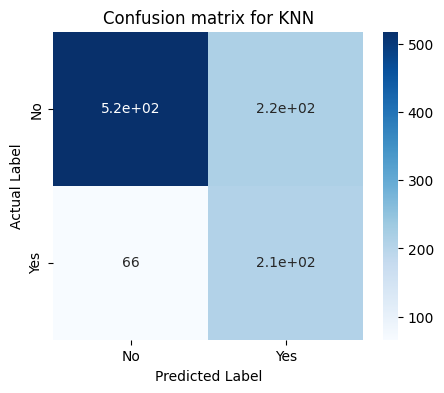

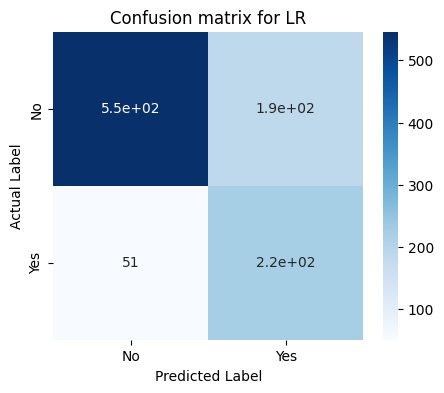

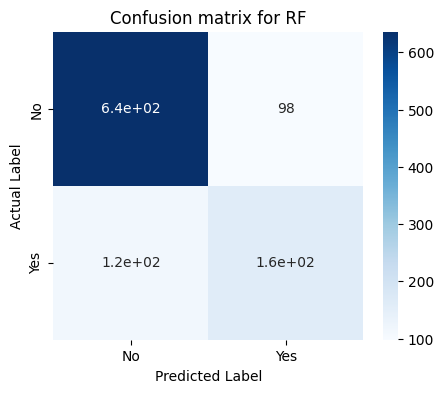

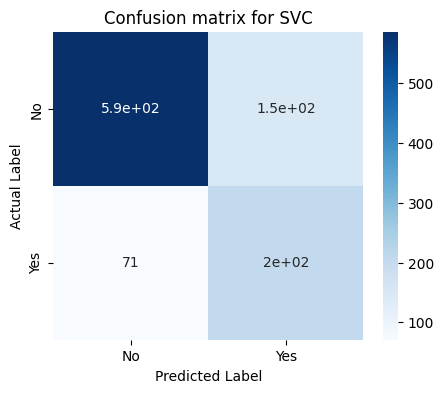

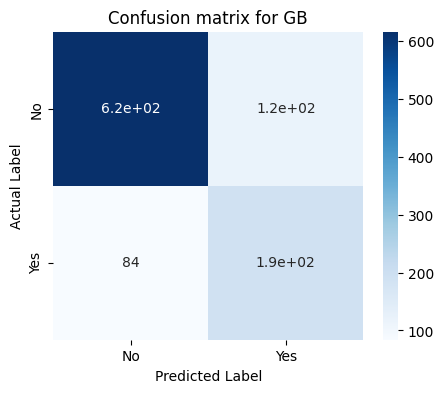

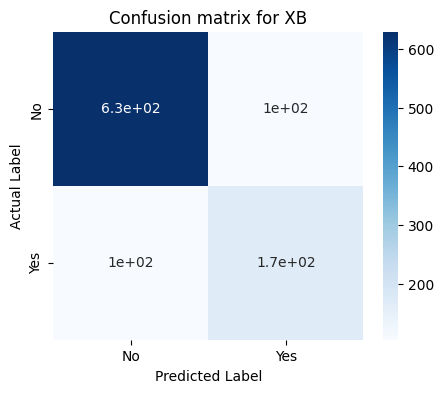

In [91]:
def confusion_matrix(conf_matrix, model):
     plt.figure(figsize = (5,4))
     sns.heatmap(conf_matrix, annot=True, cmap = 'Blues', xticklabels = ['No', 'Yes'], yticklabels = ['No','Yes'])
     plt.title(f'Confusion matrix for {model}')
     plt.xlabel('Predicted Label')
     plt.ylabel('Actual Label')
     plt.show()

for model in eval_result.keys():
    conf_matrix = eval_result[model]["confusion_matrix"]
    confusion_matrix(conf_matrix, model)



In [92]:
from sklearn.metrics import classification_report

for model, classifier in models:

    print(f'Classification Report for {model}: ')
    print(classification_report(y_val, y_pred, target_names = ['No','Yes']))
    print("=" * 30 + "\n")

Classification Report for KNN: 
              precision    recall  f1-score   support

          No       0.86      0.86      0.86       734
         Yes       0.62      0.62      0.62       275

    accuracy                           0.79      1009
   macro avg       0.74      0.74      0.74      1009
weighted avg       0.79      0.79      0.79      1009


Classification Report for LR: 
              precision    recall  f1-score   support

          No       0.86      0.86      0.86       734
         Yes       0.62      0.62      0.62       275

    accuracy                           0.79      1009
   macro avg       0.74      0.74      0.74      1009
weighted avg       0.79      0.79      0.79      1009


Classification Report for RF: 
              precision    recall  f1-score   support

          No       0.86      0.86      0.86       734
         Yes       0.62      0.62      0.62       275

    accuracy                           0.79      1009
   macro avg       0.74      0.7

HYPERPARAMETER TUNING

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
# define parameter grid for GridSearchCV
param_grid = {
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LR': {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'RF': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'GB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}
 

In [95]:
from sklearn.model_selection import StratifiedKFold


# Create an Empty DataFrame to store results
results_table = pd.DataFrame(columns = ['model','best params','best scores'])

# Initialize a list or dictionary to build the best models
best_models = { }

grid_searches_tuned = { }  # Initialize this dictionary to store the grid search results



#Hyperparameter training loop
for model, classifier in models:
    #Create the pipeline for each model
    pipeline = ImbPipeline(steps =[
        ('preprocessor', preprocessor),
        ('model', classifier)
    ])

    #Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

    #Create a GridSearch CV object 
    grid_search_tuned = GridSearchCV (
        estimator = pipeline,
        param_grid = param_grid[model],
        cv = skf,
        scoring = ['f1_weighted','f1', 'accuracy', 'precision', 'recall'],
        refit = 'f1_weighted',
        n_jobs = -1
    )

    #Fit gridsearch on train_data
    grid_search_tuned.fit(X_train, y_train)

    #Store the gridsearch object in the dictionary
    grid_searches_tuned[model] = grid_search_tuned

    #Add the results to the DataFrame 
    best_params = grid_search_tuned.best_params_
    best_score = grid_search_tuned.best_score_

    results_table.loc[len(results_table)] = [model,best_params, best_score]

#Store the best model in best_models
best_models[model]=grid_search_tuned.best_estimator_

#Sort the results table by best score
results_table = results_table.sort_values(by='best scores',ascending=False).reset_index(drop=True)

#Display the results table
results_table


    

,model,best params,best scores
0,LR,"{'model__C': 1.0, 'model__penalty': 'l1', 'mod...",0.799851
1,SVC,"{'model__C': 1.0, 'model__gamma': 'scale', 'mo...",0.797314
2,XB,"{'model__learning_rate': 0.05, 'model__max_dep...",0.796186
3,GB,"{'model__learning_rate': 0.1, 'model__max_dept...",0.795444
4,RF,"{'model__max_depth': 10, 'model__min_samples_l...",0.790893
5,KNN,"{'model__algorithm': 'auto', 'model__n_neighbo...",0.775455


In [94]:
# define parameter grid for RandomizedSearchCV
param_grid1 = {
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'LR': {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    },
    'RF': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['rbf', 'linear', 'poly']
    },
    'GB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XB': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}
 

In [104]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import pandas as pd

# Create an empty DataFrame to store results
results_table1 = pd.DataFrame(columns=['model', 'best_params', 'best_score'])

# Initialize a dictionary to store the best models
best_models1 = {}

# Hyperparameter training loop
for model, classifier in models:
    # Create the pipeline for each model
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', classifier)
    ])

    # Create a StratifiedKFold object with 3 splits
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Use RandomizedSearchCV for faster hyperparameter search
    grid_search_tuned1 = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid[model],
        cv=skf,
        scoring=['f1_weighted', 'f1', 'accuracy', 'precision', 'recall'],
        refit='f1_weighted',
        n_jobs=-1,
        n_iter=10
    )

    # Fit grid search on train data
    grid_search_tuned1.fit(X_train, y_train)

    # Store the best model in best_models and parameters
    best_models1[model] = grid_search_tuned1.best_estimator_

    # Add the results to the DataFrame
    best_params = grid_search_tuned1.best_params_
    best_score = grid_search_tuned1.best_score_

    # Use pd.concat to append the new row
    new_row = pd.DataFrame({
        'model': [model],
        'best_params': [best_params],
        'best_score': [best_score]
    })
    
    results_table1 = pd.concat([results_table1, new_row], ignore_index=True)

# Sort the results table by best_score
results_table1 = results_table1.sort_values(by='best_score', ascending=False).reset_index(drop=True)

# Display the results table
results_table1


,model,best_params,best_score
0,LR,"{'model__solver': 'liblinear', 'model__penalty...",0.796454
1,SVC,"{'model__kernel': 'linear', 'model__gamma': 'a...",0.793665
2,XB,"{'model__n_estimators': 50, 'model__max_depth'...",0.792655
3,GB,"{'model__n_estimators': 50, 'model__max_depth'...",0.789121
4,RF,"{'model__n_estimators': 50, 'model__min_sample...",0.785259
5,KNN,"{'model__weights': 'uniform', 'model__n_neighb...",0.770422


In [100]:
print(best_models)

{'XB': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('qt',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['tenure'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'SeniorCitizen', 'Pa...
           

In [105]:
print(best_models1)

{'KNN': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('qt',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['tenure'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Depen

In [108]:
# If df_scores_sorted is supposed to be a sorted version of results_table1
df_scores_sorted = results_table1.sort_values(by='best_score', ascending=False)

# Display columns of both DataFrames to check for the model column
print("Columns in df_scores_sorted:", df_scores_sorted.columns)
print("Columns in results_table:", results_table.columns)

Columns in df_scores_sorted: Index(['model', 'best_params', 'best_score'], dtype='object')
Columns in results_table: Index(['model', 'best params', 'best scores'], dtype='object')


In [114]:
# Assuming results_table1 is sorted by 'best_score'
best_model_name = results_table1.iloc[0]['model']  # Get the model name with the best score

# Retrieve the actual best model object from best_models1
best_model = best_models1[best_model_name]

# Print the best model name and object
print("Best Model Name: ", best_model_name)
print("Best Model Object: ", best_model)


Best Model Name:  LR
Best Model Object:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('qt',
                                                                   QuantileTransformer(output_distribution='normal'))]),
                                                  Index(['tenure'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', '

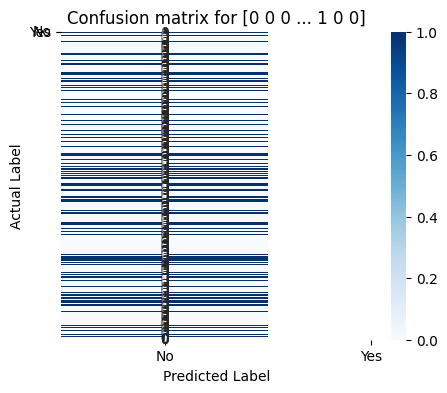

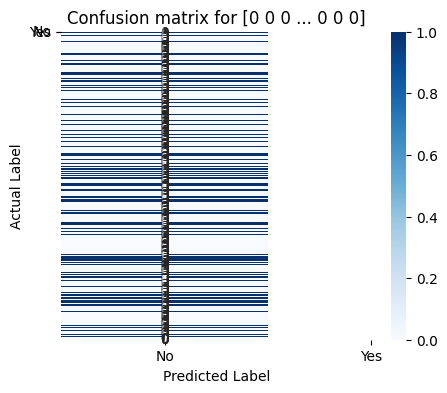

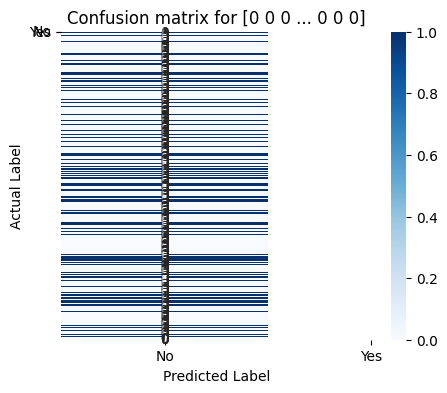

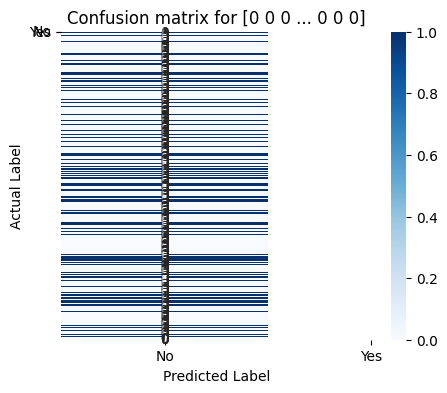

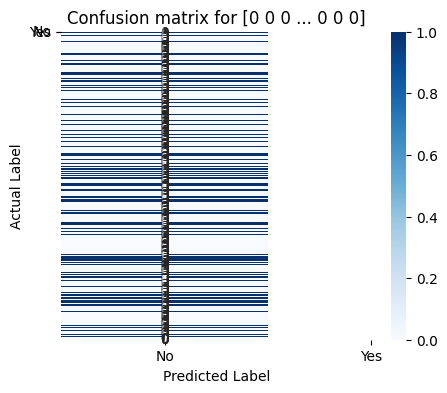

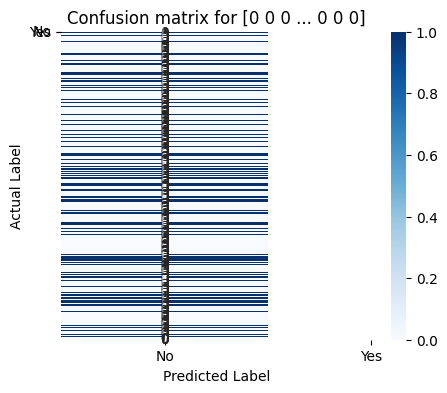

Model Scores: 


,accuracy,f1_score,precision,recall,predictions
RF,0.809713,0.606557,0.694836,0.538182,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, ..."
LR,0.802775,0.59798,0.672727,0.538182,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ..."
SVC,0.801784,0.596774,0.669683,0.538182,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ..."
GB,0.804757,0.592133,0.6875,0.52,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, ..."
XB,0.801784,0.588477,0.677725,0.52,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, ..."
KNN,0.778989,0.573614,0.604839,0.545455,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ..."


In [115]:
eval_results_tuned = { }

for model, grid_search_tuned in grid_searches_tuned.items():
    y_pred = grid_search_tuned.predict(X_val)

    
    

    accuracy = accuracy_score (y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    precision = precision_score (y_val,y_pred)
    recall = recall_score(y_val,y_pred)
    conf_matrix = confusion_matrix(y_val.reshape(-1,1), y_pred)

    #Store the results
    eval_results_tuned[model] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,

    }

df_scores_tuned = pd.DataFrame(eval_results_tuned).transpose()
df_scores_tuned_sorted = df_scores_tuned.sort_values(by = "f1_score", ascending = False)

print ("Model Scores: ")
df_scores_tuned_sorted


Use The Best Model on the Test Set 

In [116]:
#Copy test_data
test_set = test_data.copy()

In [117]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   object 
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [120]:
test_set.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64

In [121]:
test_set.dropna(subset='TotalCharges',inplace=True)

In [122]:
best_estimators = {}

y_test = {}

for model in ['RF','LR']:
    if model in grid_searches_tuned:
        best_estimators[model]=grid_searches_tuned[model].best_estimator_

    else:
        print(f'{model} not found')

In [129]:
for col in test_set.columns:
    print(f"Column: {col}, Type: {test_set[col].dtype}")
    # check if applying np.isnan would fail
    try:
        np.isnan(test_set[col])
    except TypeError:
        print(f"np.isnan() not applicable to column: {col}")

Column: gender, Type: object
np.isnan() not applicable to column: gender
Column: SeniorCitizen, Type: object
np.isnan() not applicable to column: SeniorCitizen
Column: Partner, Type: object
np.isnan() not applicable to column: Partner
Column: Dependents, Type: object
np.isnan() not applicable to column: Dependents
Column: tenure, Type: int64
Column: PhoneService, Type: object
np.isnan() not applicable to column: PhoneService
Column: MultipleLines, Type: object
np.isnan() not applicable to column: MultipleLines
Column: InternetService, Type: object
np.isnan() not applicable to column: InternetService
Column: OnlineSecurity, Type: object
np.isnan() not applicable to column: OnlineSecurity
Column: OnlineBackup, Type: object
np.isnan() not applicable to column: OnlineBackup
Column: DeviceProtection, Type: object
np.isnan() not applicable to column: DeviceProtection
Column: TechSupport, Type: object
np.isnan() not applicable to column: TechSupport
Column: StreamingTV, Type: object
np.isnan(

In [130]:
#1. Select only numeric columns
numeric_cols = test_set.select_dtypes(include=['float64','int64'])

#2. Find rows where there are NaN values in numeric columns 
nan_rows = numeric_cols.isna().any(axis=1)

#3. Use the boolean mask to filter the original DataFrame
rows_with_nan = test_set[nan_rows]

# Display the rows with NaN values 
rows_with_nan

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [131]:
# Select only numeric columns from the DataFrame
numeric_cols = test_set.select_dtypes(include=['float64','int64'])

#Apply np.isnanonly to numeric columns
nan_mask = numeric_cols.apply(lambda col:np.isnan(col))

In [132]:
# Convert 'TotalCharges' to numeric setting errors to Nan
test_set['TotalCharges'] = pd.to_numeric(test_set['TotalCharges'], errors = 'coerce')

In [133]:
# Filling for Numerical total changes 
#test_set[col].replace("NaN",np.nan,inplace=True) 

test_set ['TotalCharges'].fillna(test_set['TotalCharges'].median(), inplace=True)

In [134]:
# Check if columns in test_set match those in the training data
print(test_set.columns)
print(X_train.columns) # Assuming X_train was the training data

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'mc_category'],
      dtype='object')


In [135]:
# Using the test_set
test_set['SeniorCitizen'] = test_set['SeniorCitizen'].replace({0:'No', 1:'Yes'}, inplace = True)

In [136]:
best_estimators = {}

y_test = {}

for model in ['RF','LR']:
    if model in grid_searches_tuned:
        best_estimators[model]=grid_searches_tuned[model].best_estimator_

    else:
        print(f'{model} not found')

In [141]:
#for model, model in best_estimators.items():
    #y_test[model]=model.predict(test_set)

ValueError: columns are missing: {'mc_category'}

In [145]:
# Check if 'mc_category' is present in the test_set
if 'mc_category' not in test_set.columns:
    print("Column 'mc_category' is missing from test_set. Adding it back.")
    # Fill in 'mc_category' with an appropriate default value
    # This value should match whatever you used during training preprocessing
    test_set['mc_category'] = 'default_category'  # Replace with appropriate value or imputation strategy

# Now loop through models and make predictions
for model_name, model_object in best_estimators.items():
    # Make predictions using the preprocessed test_set
    y_test[model_name] = model_object.predict(test_set)
